# Amazon Product Classification with CNN

In [ ]:
import tensorflow as tf
 
# Display the version
print(tf.__version__)     
 
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

### Hyperparameters

In [2]:
batch_size = 32
epochs = 5
filter_size = 3
group_1_dim = 32
group_2_dim = 64
group_3_dim = 128
dense_dim = 1024

dropout_rate = 0.2

### Load the image data

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\haoxu\Documents\ecec147\cifar10_tensorflow\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="training",
                                                 seed=123)

val_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\haoxu\Documents\ecec147\cifar10_tensorflow\img_uniform_split\train", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(r"C:\Users\haoxu\Documents\ecec147\cifar10_tensorflow\img_uniform_split\test", 
                                                 labels='inferred', 
                                                 image_size=(64,64), 
                                                 batch_size=batch_size)

class_names = train_ds.class_names

print(class_names)
print(train_ds.cardinality())
print(val_ds.cardinality())

Found 89663 files belonging to 10 classes.
Using 71731 files for training.
Found 89663 files belonging to 10 classes.
Using 17932 files for validation.
Found 9966 files belonging to 10 classes.
['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food', 'health & personal care', 'musical instruments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']
tf.Tensor(2242, shape=(), dtype=int64)
tf.Tensor(561, shape=(), dtype=int64)


### Visualize images

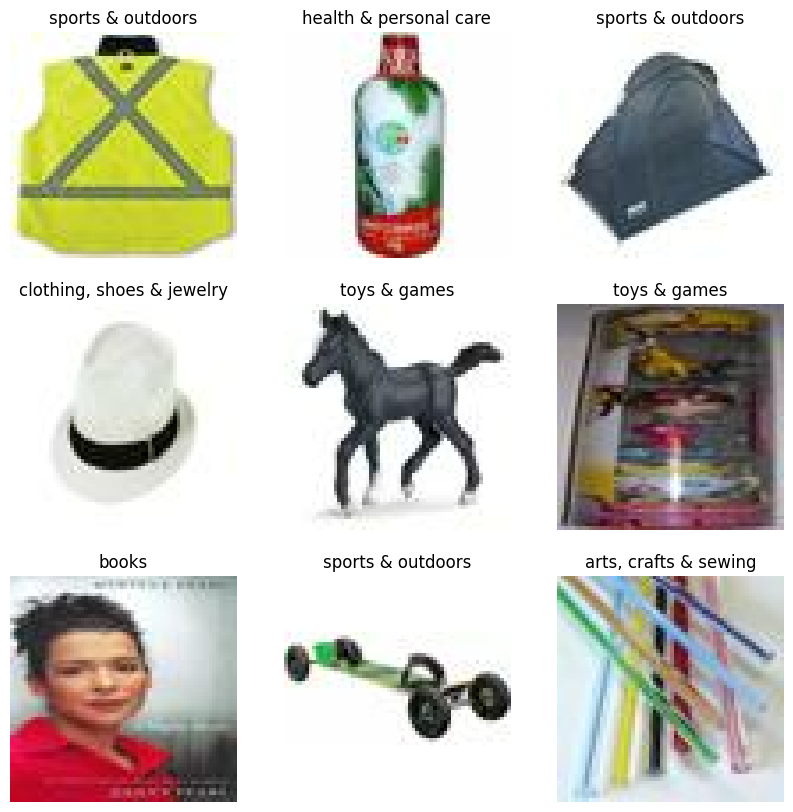

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalize Data

In [ ]:
# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

### Improve loading speed

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
])

### Define Model Architecture

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  
  # Group 1
  tf.keras.layers.Conv2D(group_1_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_1_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  # Group 2
  tf.keras.layers.Conv2D(group_2_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_2_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  # Group 3
  tf.keras.layers.Conv2D(group_3_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(group_3_dim, filter_size, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(dropout_rate),
  
  # Dense
  tf.keras.layers.Dense(dense_dim, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Dense(dense_dim, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  
  tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train Model

In [11]:
# Fit
with tf.device('/cpu:0'):
  r = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  )

Epoch 1/100


2242/2242 [==============================] - 227s 101ms/step - loss: 1.7954 - accuracy: 0.3631 - val_loss: 1.8218 - val_accuracy: 0.3474
Epoch 2/100
2242/2242 [==============================] - 230s 103ms/step - loss: 1.7274 - accuracy: 0.3876 - val_loss: 1.6935 - val_accuracy: 0.4021
Epoch 3/100
2242/2242 [==============================] - 229s 102ms/step - loss: 1.6722 - accuracy: 0.4110 - val_loss: 1.6767 - val_accuracy: 0.4101
Epoch 4/100
2242/2242 [==============================] - 225s 100ms/step - loss: 1.6191 - accuracy: 0.4318 - val_loss: 1.6336 - val_accuracy: 0.4263
Epoch 5/100
2242/2242 [==============================] - 226s 101ms/step - loss: 1.5746 - accuracy: 0.4466 - val_loss: 1.6919 - val_accuracy: 0.3982
Epoch 6/100
2242/2242 [==============================] - 230s 102ms/step - loss: 1.5291 - accuracy: 0.4635 - val_loss: 1.5725 - val_accuracy: 0.4480
Epoch 7/100
2242/2242 [==============================] - 232s 104ms/step - loss: 1.4834 - accuracy: 0.4795 - val_loss:

In [16]:
model.save(r"C:\Users\haoxu\Documents\ecec147\cifar10_tensorflow\models\cnn_model.keras")

### Evaluate Model

In [13]:
predictions = model.predict(test_ds)
prediction_df = pd.DataFrame(predictions, columns=class_names)

predicted_labels = np.argmax(predictions, axis=1)

# Measure test accuracy
test_results = {}
test_results['model'] = model.evaluate(test_ds, verbose=0)

print(f" Accuracy: {test_results}")

312/312 [==============================] - 15s 45ms/step
 Accuracy: {'model': [1.6039950847625732, 0.45344170928001404]}


<AxesSubplot: xlabel='Predicted Label', ylabel='True Label'>

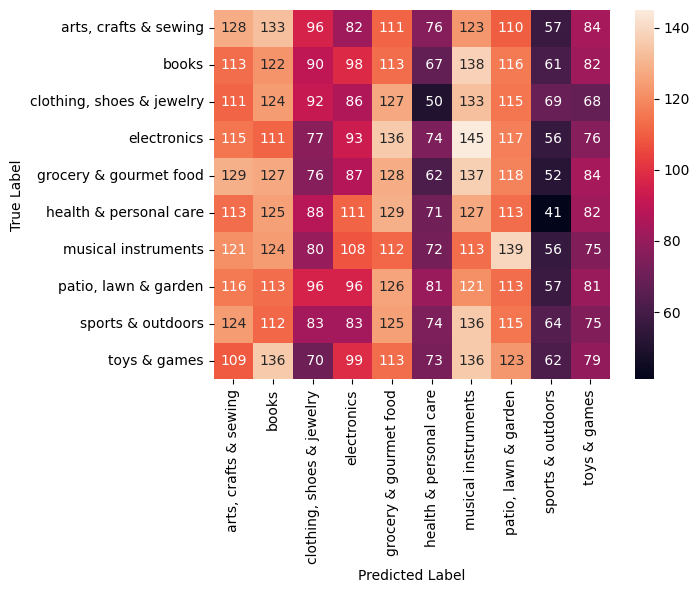

In [14]:
import seaborn as sns

# create a confusion matrix
y_test = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_test, predicted_labels)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(cm, index=class_names, columns=class_names)
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt='3g')

### Predict Various Images from Test Set

1/1 [==============================] - 0s 119ms/step
toys & games
The model predicted this image to be patio, lawn & garden and it is actually toys & games


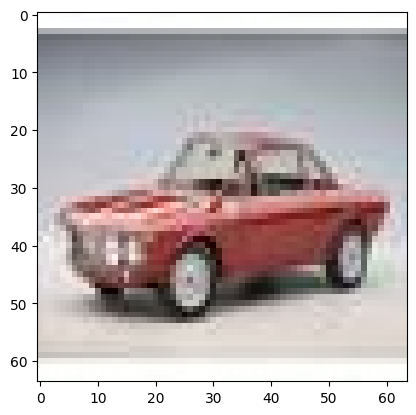

In [67]:
labels =['arts, crafts & sewing', 'books', 'clothing, shoes & jewelry', 'electronics', 'grocery & gourmet food',  
         'health & personal care', 'musical instrucments', 'patio, lawn & garden', 'sports & outdoors', 'toys & games']
 
image_number = 0
 

first_element = test_ds.take(1)
for image, label in first_element:
  n = np.array(image[0].numpy().astype("uint8"))
  p = n.reshape(1, 64, 64, 3)
  plt.imshow(p[0].astype("uint8"))
  predicted_label = labels[model.predict(p).argmax()]
 
original_label = labels[label[image_number].numpy()]
print(original_label)
 
print("The model predicted this image to be", predicted_label, "and it is actually", original_label)

### Predict an Image not from Amazon

1/1 [==============================] - 0s 46ms/step
The model predicted this image to be toys & games


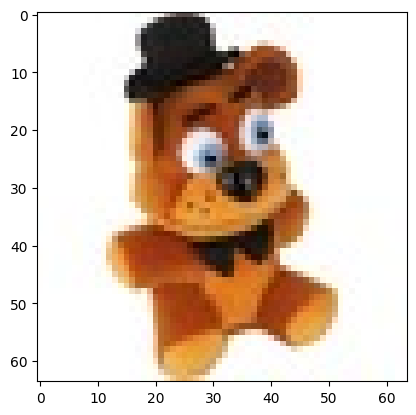

In [66]:
from PIL import Image

freddy = Image.open(r"C:\Users\haoxu\Documents\ecec147\cifar10_tensorflow\freddy.jpg")
plt.imshow(freddy)

n = np.array(freddy)
p = n.reshape(1, 64, 64, 3)
predicted_label = labels[model.predict(p).argmax()]

print("The model predicted this image to be", predicted_label)